## Covid-19 Analysis: Spread, Containment and Future steps 

Since the Ebola outbreak in 2014, there were number of alarms raised worldwide by scientists, healthcare experts and even enterpreneurs like Bill Gates about a potential pandemic that could wreak havoc on our world. But did the countries listen?

In this project, we will try to figure out the same answer. The key questions which we would look to answer:

* Which Countries have invested more in their healthcare before the pandemic?
* Have these Countries been less impacted by Covid Pandemic as compared to others(in terms of deaths,number of recovered patients)?
* Did these countries carry out more tests as compared to others?
* Is there any significant difference between earlier death rate and death rate impacted by Covid?

Finally, a model is built incorporating all these factors to predict the deaths per 1M population anf it's perfromance is evaluated.

The data which I am going to use for this project is:

* Covid-19 Cases Worldwide dataset (Source: https://www.worldometers.info/coronavirus/)
* World Developement Indicators from 2015-2018 (Source: http://api.worldbank.org/v2/en/topic/8?downloadformat=csv)

**Loading required libraries:**

In [54]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

### Data Acquistion & Cleaning

**Covid-19 Cases Worldwide data:**

Web-Scraping was used to extract data from the "Worldometer CoronaVirus" website since it has the latest and most reliable statistics about the COVID-19 pandemic. Also its data is widely used worldwide by a number of famous organizations and publications in reporting latest news about COVID. 

In [2]:
URL = 'https://www.worldometers.info/coronavirus/'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

We are going to extract data only from the main table which lists out all countries and their statistics as of today.

In [3]:
results = soup.find(id='main_table_countries_today')
covidData = pd.read_html(results.prettify())[0]

In [4]:
covidData.head()

,"Country, Other",Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,"Serious, Critical",Tot Cases/ 1M pop,Deaths/ 1M pop,Total Tests,Tests/ 1M pop
0,World,2402980,"+72,214",165641.0,"+5,594",615703.0,1621636,54215.0,308.0,21.3,NaN,NaN
1,USA,762496,"+23,704",40478.0,"+1,464",69956.0,652062,13556.0,2304.0,122.0,3852758.0,11640.0
2,Spain,198674,"+4,258",21238.0,"+1,195",77357.0,100079,7371.0,4249.0,454.0,930230.0,19896.0
3,Italy,178972,"+3,047",23660.0,+433,47055.0,108257,2635.0,2960.0,391.0,1356541.0,22436.0
4,France,152894,"+1,101",19718.0,+395,36578.0,96598,5744.0,2342.0,302.0,463662.0,7103.0


In [5]:
covidData.shape

(214, 12)

The data is of 213 countries with 12 features. Some key insights about the data:

In [6]:
print("Total Number of Cases Worldwide:",covidData['Total  Cases'][0])
print("Total Number of Deaths Worldwide:",covidData['Total  Deaths'][0])
print("Total Number of Recovered Patients Worldwide:",covidData['Total  Recovered'][0])

Total Number of Cases Worldwide: 2402980
Total Number of Deaths Worldwide: 165641.0
Total Number of Recovered Patients Worldwide: 615703.0


In [7]:
print("Percent of Active cases in Serious condition: " + "{0:.0%}".format(covidData['Serious,  Critical'][0]/covidData['Active  Cases'][0]))

Percent of Active cases in Serious condition: 3%


We can observe that 3% of the current active cases are in serious or critical condition.

In [8]:
##Removing observation about world since it is going to be merged with other datasets
covidDf = covidData[1:]
## Removing '+' in New Cases and New Deaths
covidDf['New  Cases'] = covidDf['New  Cases'].dropna().str.replace(',', '').str.replace('$', '').astype(int)
covidDf['New  Deaths'] = covidDf['New  Deaths'].dropna().str.replace(',', '').str.replace('$', '').astype(int)
covidDf.rename(columns = {'Country,  Other':'Country'}, inplace = True);

In [61]:
covidDf.head()

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,"Serious, Critical",Tot Cases/ 1M pop,Deaths/ 1M pop,Total Tests,Tests/ 1M pop
1,USA,762496,23704.0,40478.0,1464.0,69956.0,652062,13556.0,2304.0,122.0,3852758.0,11640.0
2,Spain,198674,4258.0,21238.0,1195.0,77357.0,100079,7371.0,4249.0,454.0,930230.0,19896.0
3,Italy,178972,3047.0,23660.0,433.0,47055.0,108257,2635.0,2960.0,391.0,1356541.0,22436.0
4,France,152894,1101.0,19718.0,395.0,36578.0,96598,5744.0,2342.0,302.0,463662.0,7103.0
5,Germany,145184,1460.0,4586.0,48.0,88000.0,52598,2889.0,1733.0,55.0,1728357.0,20629.0
6,UK,120067,5850.0,16060.0,596.0,NaN,103663,1559.0,1769.0,237.0,482063.0,7101.0


In [10]:
covidDf.dtypes

Country                object
Total  Cases            int64
New  Cases            float64
Total  Deaths         float64
New  Deaths           float64
Total  Recovered      float64
Active  Cases           int64
Serious,  Critical    float64
Tot Cases/  1M pop    float64
Deaths/  1M pop       float64
Total  Tests          float64
Tests/  1M pop        float64
dtype: object

**Check Percent of Missing Values:**

In [11]:
def missing_values(df):
    miss_summary = pd.DataFrame(columns=['variable','missing_values', 'missing_%'])
    columns = df.columns
    for col in columns:
        col_name = col
        count = df[col].isnull().sum()
        percentage = round((df[col].isna().sum()/df[col].shape[0])*100,2)
        miss_summary.loc[len(miss_summary)] = [col_name, count, percentage]
        miss_summary.sort_values('missing_values',ascending=False,inplace=True)
    print(miss_summary)

missing_values(covidDf)

              variable missing_values  missing_%
4          New  Deaths            128      60.09
7   Serious,  Critical             76      35.68
2           New  Cases             73      34.27
9      Deaths/  1M pop             48      22.54
10        Total  Tests             47      22.07
11      Tests/  1M pop             47      22.07
3        Total  Deaths             46      21.60
5     Total  Recovered             15       7.04
8   Tot Cases/  1M pop              2       0.94
0              Country              0       0.00
1         Total  Cases              0       0.00
6        Active  Cases              0       0.00


**Data Quality Insights:**
* High percent of missing values in "New Deaths" - probably because of no new death recorded today or the data has still not been provided by the respective country
* Similar is the case with "New Cases"
* Rest of the missing values are also highly dependent on each country health agencies, their transparency and other factors
* Proceeding without imputing this data since it will highly distort our further analysis

**World Development Indicators Data:**

In [62]:
wdiData = pd.read_csv("data/WDIndicators.csv")

In [64]:
wdiData.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Specialist surgical workforce (per 100,000 pop...",SH.MED.SAOP.P5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,ABW,"Physicians (per 1,000 people)",SH.MED.PHYS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,ABW,"Nurses and midwives (per 1,000 people)",SH.MED.NUMW.P3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,ABW,"Community health workers (per 1,000 people)",SH.MED.CMHW.P3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,ABW,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since the data contains World Development indicators from 1960 to 2019, we are only concentrating for the year 2017 since most of the data is missing for the years 2018 and 2019 and we could get an idea of country's health indicators before the pandemic hit.

In [65]:
colsubset = ['Country Name', 'Indicator Name','2017']
wdiDataNew = wdiData[colsubset]
wdiDataNew.head()

,Country Name,Indicator Name,2017
0,Aruba,"Specialist surgical workforce (per 100,000 pop...",NaN
1,Aruba,"Physicians (per 1,000 people)",NaN
2,Aruba,"Nurses and midwives (per 1,000 people)",NaN
3,Aruba,"Community health workers (per 1,000 people)",NaN
4,Aruba,"Hospital beds (per 1,000 people)",NaN


**Filtering for the required indicators:**

In [66]:
reqIndicators = ['Hospital beds (per 1,000 people)','Physicians (per 1,000 people)','Life expectancy at birth, total (years)',
                 'Current health expenditure (% of GDP)','Current health expenditure per capita, PPP (current international $)'
                ,'Death rate, crude (per 1,000 people)','Population ages 65 and above, total','Population, total']
wdiDataNew  =wdiDataNew[wdiDataNew['Indicator Name'].isin(reqIndicators)]

The  data is in long format. We have to convert it into wide format in order to further merge with the covid dataset.

**Reshaping the data:**

In [67]:
wdiDataNew.rename(columns = {'Country Name':'Country'}, inplace = True)

wdiDataV1 = wdiDataNew.pivot(index='Country', columns='Indicator Name', values='2017')
wdiDataV2 = wdiDataV1.reset_index()


In [17]:
missing_values(wdiDataV2)

                                            variable missing_values  missing_%
4                   Hospital beds (per 1,000 people)            264     100.00
6                      Physicians (per 1,000 people)            215      81.44
2  Current health expenditure per capita, PPP (cu...             79      29.92
1              Current health expenditure (% of GDP)             33      12.50
7                Population ages 65 and above, total             25       9.47
5            Life expectancy at birth, total (years)             19       7.20
3               Death rate, crude (per 1,000 people)             13       4.92
8                                  Population, total              2       0.76
0                                            Country              0       0.00


**Data Quality Insights:**
* High percent of missing values in Hospital beds and Physicians, so removing them
* Using only "Current health expenditure (% of GDP)" beacuse less percent of missing values as compared to per capita

In [68]:
wdiDataFinal = wdiDataV2.drop(['Hospital beds (per 1,000 people)','Physicians (per 1,000 people)',
                               'Current health expenditure per capita, PPP (current international $)'],axis=1)

In [19]:
missing_values(wdiDataFinal)

                                  variable missing_values  missing_%
1    Current health expenditure (% of GDP)             33      12.50
4      Population ages 65 and above, total             25       9.47
3  Life expectancy at birth, total (years)             19       7.20
2     Death rate, crude (per 1,000 people)             13       4.92
5                        Population, total              2       0.76
0                                  Country              0       0.00


**Merging the two data on country:**

In [69]:
covid_wdi = covidDf.merge(wdiDataFinal, left_on='Country', right_on='Country')

In [70]:
covid_wdi.head()

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,"Serious, Critical",Tot Cases/ 1M pop,Deaths/ 1M pop,Total Tests,Tests/ 1M pop,Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)","Life expectancy at birth, total (years)","Population ages 65 and above, total","Population, total"
0,USA,762496,23704.0,40478.0,1464.0,69956.0,652062,13556.0,2304.0,122.0,3852758.0,11640.0,17.061269,8.638,78.539024,50110709.0,324985539.0
1,Spain,198674,4258.0,21238.0,1195.0,77357.0,100079,7371.0,4249.0,454.0,930230.0,19896.0,8.873130,9.100,83.282927,8920670.0,46593236.0
2,Italy,178972,3047.0,23660.0,433.0,47055.0,108257,2635.0,2960.0,391.0,1356541.0,22436.0,8.840259,10.700,82.946341,13620571.0,60536709.0
3,France,152894,1101.0,19718.0,395.0,36578.0,96598,5744.0,2342.0,302.0,463662.0,7103.0,11.312892,9.100,82.526829,13151703.0,66865144.0
4,Germany,145184,1460.0,4586.0,48.0,88000.0,52598,2889.0,1733.0,55.0,1728357.0,20629.0,11.246835,11.300,80.992683,17665031.0,82657002.0


In [22]:
missing_values(covid_wdi)

                                   variable missing_values  missing_%
4                               New  Deaths             93      56.36
7                        Serious,  Critical             51      30.91
2                                New  Cases             48      29.09
3                             Total  Deaths             28      16.97
9                           Deaths/  1M pop             28      16.97
10                             Total  Tests             26      15.76
11                           Tests/  1M pop             26      15.76
12    Current health expenditure (% of GDP)             15       9.09
15      Population ages 65 and above, total             12       7.27
14  Life expectancy at birth, total (years)              9       5.45
5                          Total  Recovered              7       4.24
13     Death rate, crude (per 1,000 people)              6       3.64
16                        Population, total              1       0.61
0                   

### Visualizations & Insights

Now since we have the final data ready, it's time to perform Exploratory Data Analysis to find out some key answers.

**Highest Number of Cases:** 

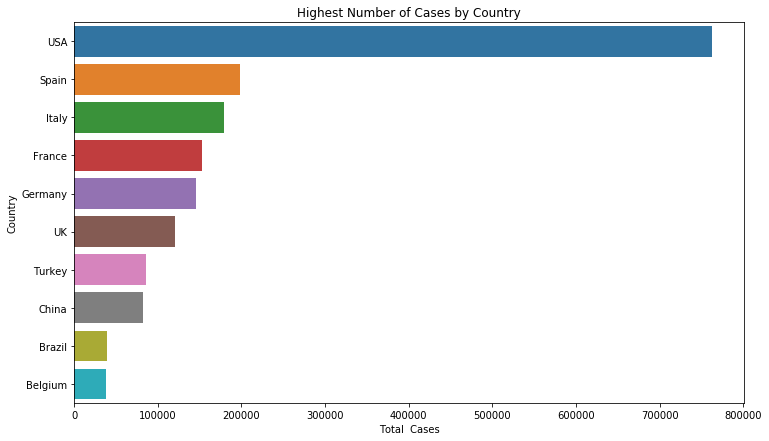

In [85]:
covid10 = covid_wdi.sort_values(by='Total  Cases', ascending=False).head(10)
plt.figure(figsize=(12,7))
sns.barplot(x="Total  Cases", y="Country", data=covid10)
plt.title('Highest Number of Cases by Country');

**Highest Number of Deaths:**

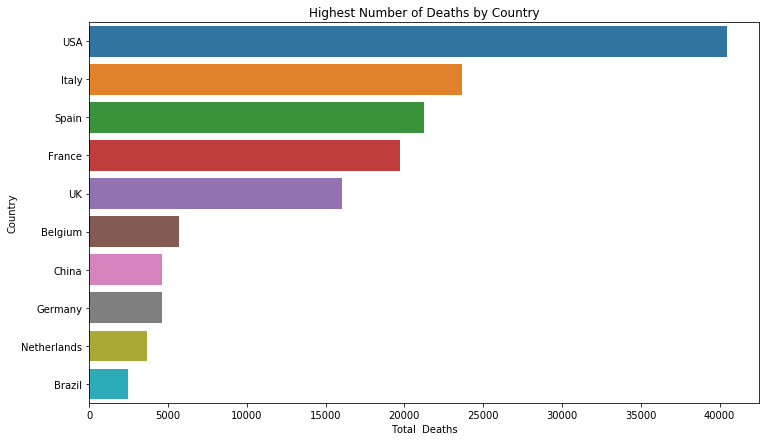

In [80]:
covid10_v1 = covid_wdi.sort_values(by='Total  Deaths', ascending=False).head(10)
f, ax = plt.subplots(figsize=(12,7))
sns.barplot(x="Total  Deaths", y="Country", data=covid10_v1)
plt.title('Highest Number of Deaths by Country');

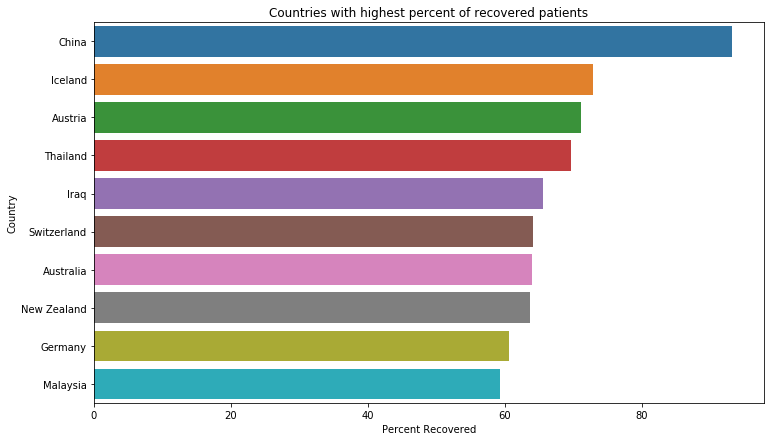

In [59]:
covid_rec = covid_wdi.copy()
covid_rec = covid_rec[covid_rec["Total  Cases"] > 1000]
covid_rec["Percent Recovered"] = covid_rec["Total  Recovered"]*100/covid_rec["Total  Cases"]
covid_rec = covid_rec.sort_values(by="Percent Recovered", ascending=False).head(10)
f, ax = plt.subplots(figsize=(12,7))
sns.barplot(x="Percent Recovered", y="Country", data=covid_rec)
plt.title('Countries with highest percent of recovered patients');

**Key insights from above plots:**

* Countries with most cases and most deaths are more or less the same. Countries like USA, Spain, Italy, France and UK have been impacted the most.
* China, although initially had large number of cases but most of them are recovered.
* Iceland, Austria and Thailand are other countries which have high percent of recovered patients(**Note:**Only Countries where number of cases have exceeded 1000 are taken)

**Do Countries with high health expenditure have done more testing?**

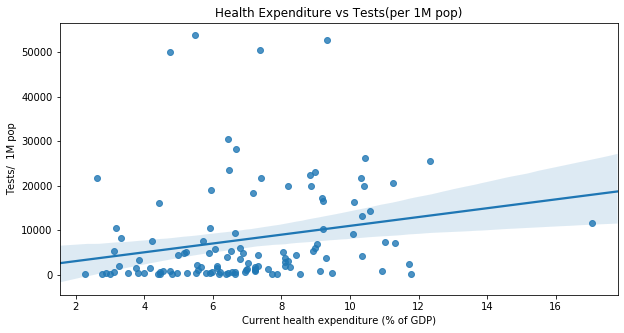

In [26]:
plt.figure(figsize=(10,5))
sns.regplot(x='Current health expenditure (% of GDP)',y='Tests/  1M pop',data=covid_wdi[(covid_wdi['Tests/  1M pop']>100) & 
                                                                                           (covid_wdi['Tests/  1M pop']<60000)])
plt.title('Health Expenditure vs Tests(per 1M pop)');

We can observe a slight positive linear relation between Tests carried out and Health expenditure of a country.

**Do countries with higher deaths have high percent of population above 65 age?**

In [27]:
covid_wdi['Percent_Above65'] = (covid_wdi['Population ages 65 and above, total']/covid_wdi['Population, total'])*100

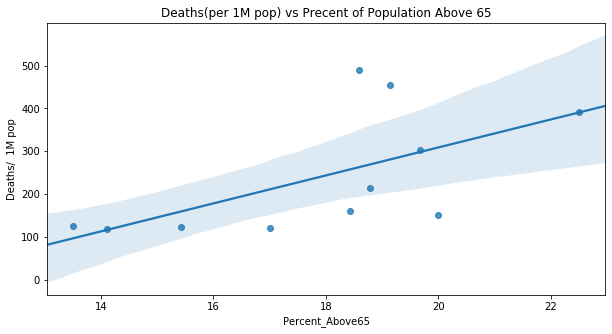

In [28]:
plt.figure(figsize=(10,5))
sns.regplot(x='Percent_Above65',y='Deaths/  1M pop',data=covid_wdi[covid_wdi['Deaths/  1M pop']>100])
plt.title('Deaths(per 1M pop) vs Precent of Population Above 65');

One interesting observation from the above plot is that for countries with higher deaths(at least 100 per 1M population ), there seems to be a highly linear relationship between Deaths and Percent of population above 65.

**Is COVID-19 causing higher death rate as compared to earlier?**

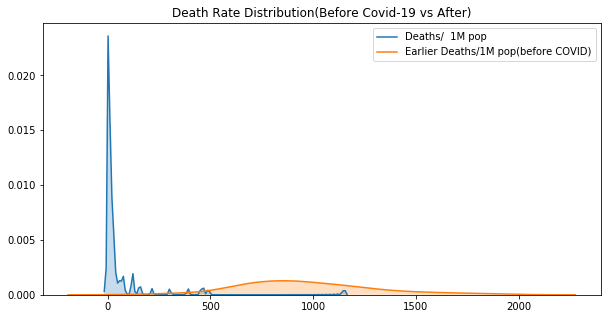

In [52]:
covid_wdi_new = covid_wdi.copy()
covid_wdi_new['Earlier Deaths/1M pop(before COVID)'] = covid_wdi_new['Death rate, crude (per 1,000 people)']*(1000/8)
plt.figure(figsize=(10,5))
sns.kdeplot(covid_wdi_new['Deaths/  1M pop'], shade=True)
sns.kdeplot(covid_wdi_new['Earlier Deaths/1M pop(before COVID)'], shade=True)
plt.title('Death Rate Distribution(Before Covid-19 vs After)');

In order to compare the earlier death rate with the present, the "Death Rate" column was mapped to 1M population and also calculated for 1.5 months in order to have a fair comparison with Deaths due to Covid-19(which has also lasted about the same time).

Some insights:
* Covid-19 death rate is highly right-skewed with quite high number of deaths now reported
* The magnitude of individual death numbers for each country is however low as compared to earlier rate. The reason might be because of social distancing less crimes, less road accidents etc but at the same time the effect of pandemic will be seen in a long run and it will be fair to compare these rates after this year.

### Model Building

Since we have done the initial exploratory data analysis, we are going to build two regression models to predict "Deaths / 1M pop". We are not going to use "Total Deaths" because it doesn't take the population of given country into account. We are also taking countries which have Deaths per 1M pop at least greater than 10 in order to remove any discrepancies in the data reporting of these countries.

**Response Variable:** Deaths / 1M pop

In [29]:
## Removing "New Deaths", "Serious,  Critical" and "New  Cases" beacuse of high percent of missing values

colsRemoved = ["New  Deaths", "Serious,  Critical","New  Cases"]
modelData = covid_wdi.drop(colsRemoved,axis=1)
modelData = modelData.dropna()

In [30]:
modelData.describe()

,Total Cases,Total Deaths,Total Recovered,Active Cases,Tot Cases/ 1M pop,Deaths/ 1M pop,Total Tests,Tests/ 1M pop,Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)","Life expectancy at birth, total (years)","Population ages 65 and above, total","Population, total",Percent_Above65
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,1.040000e+02,104.000000,104.000000,104.000000,104.000000,1.040000e+02,1.040000e+02,104.000000
mean,19507.442308,1329.990385,4422.980769,13754.471154,665.825000,33.313558,1.473213e+05,8966.317308,7.026058,7.933231,74.960230,3.982866e+06,4.582444e+07,10.923667
std,80914.011573,5344.242476,14378.807479,66013.930503,1079.975183,84.880505,4.416389e+05,15579.563077,2.600210,2.872005,6.468089,1.008298e+07,1.398707e+08,6.470185
min,7.000000,1.000000,2.000000,0.000000,0.900000,0.030000,7.300000e+01,22.000000,2.274249,1.169000,53.950000,8.183000e+03,9.542600e+04,1.232125
25%,519.250000,8.000000,86.250000,397.250000,46.500000,1.000000,9.352250e+03,545.750000,5.117204,5.909500,71.984244,3.911250e+05,4.012079e+06,5.201752
50%,1876.000000,47.000000,337.000000,1233.000000,190.000000,4.500000,3.951700e+04,3641.000000,6.834562,7.352000,75.822537,1.041670e+06,1.040672e+07,9.687051
75%,7412.250000,228.500000,1085.500000,5486.500000,756.250000,20.250000,9.901600e+04,10707.000000,8.887764,9.525000,80.153750,2.970216e+06,3.679569e+07,16.836851
max,762496.000000,40478.000000,88000.000000,652062.000000,5671.000000,490.000000,3.852758e+06,120416.000000,17.061269,15.500000,84.099756,8.009348e+07,1.338659e+09,27.109480


**Correlation Matrix:**

Population, total                         -0.017470
Population ages 65 and above, total        0.122193
Death rate, crude (per 1,000 people)       0.151056
Tests/  1M pop                             0.198424
Active  Cases                              0.314400
Total  Tests                               0.367780
Current health expenditure (% of GDP)      0.375698
Life expectancy at birth, total (years)    0.386487
Total  Cases                               0.400877
Percent_Above65                            0.424455
Total  Recovered                           0.574824
Total  Deaths                              0.639283
Tot Cases/  1M pop                         0.689164
Deaths/  1M pop                            1.000000
Name: Deaths/  1M pop, dtype: float64


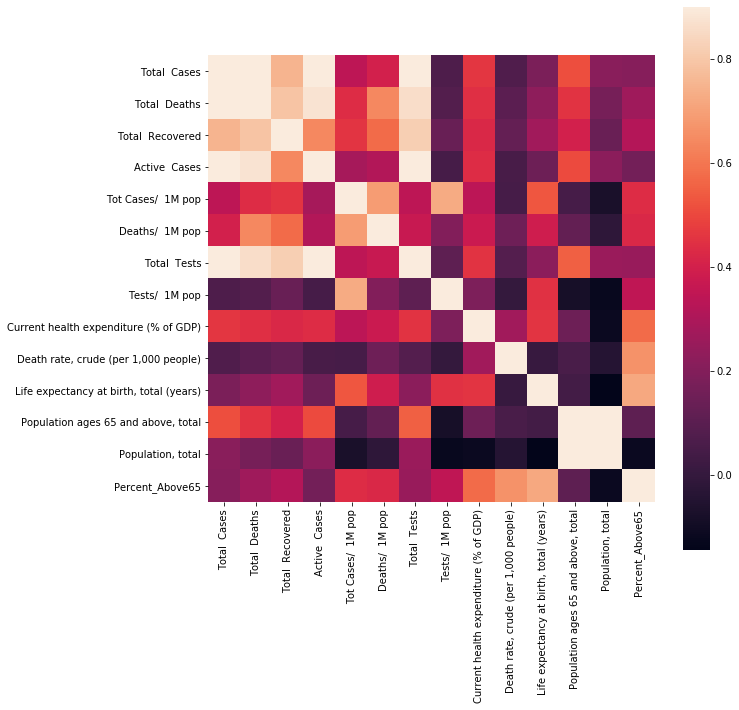

In [31]:
corr=modelData.corr()
corr_delay=corr['Deaths/  1M pop'].sort_values()
print(corr_delay)

plt.subplots(figsize=(10,10))
chart=sns.heatmap(corr, vmax=0.9, square=True);
chart.set_yticklabels(chart.get_yticklabels(), rotation=0);

From above correlation matrix we can see that many of the predictor variables are highly correlated among themselves like:

* Total Cases and Total Deaths
* Total Cases and Active Cases
* Population above 65 and Total Population
* Total Tests and Total Cases, Total Deaths

Using only one or the other variable to avoid multicollinearity:

In [32]:
cols_rem = ['Total  Deaths','Active  Cases','Population ages 65 and above, total','Population, total']
finalModelData = modelData.drop(cols_rem,axis=1)

#### Linear Regression Model

In [33]:
X=finalModelData.drop(['Deaths/  1M pop','Country'],1)
Y=finalModelData['Deaths/  1M pop']

X.columns.values

array(['Total  Cases', 'Total  Recovered', 'Tot\xa0Cases/  1M pop',
       'Total  Tests', 'Tests/  1M pop',
       'Current health expenditure (% of GDP)',
       'Death rate, crude (per 1,000 people)',
       'Life expectancy at birth, total (years)', 'Percent_Above65'],
      dtype=object)

In [34]:
# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [35]:
model=LinearRegression(fit_intercept=True)
model.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
model_summary = pd.DataFrame({'Predictor':X.columns,'Coeffcient_Values':model.coef_})
model_summary.sort_values(by='Coeffcient_Values', ascending=False)

,Predictor,Coeffcient_Values
8,Percent_Above65,2.790407
5,Current health expenditure (% of GDP),1.452570
2,Tot Cases/ 1M pop,0.101260
0,Total Cases,-0.000005
3,Total Tests,-0.000012
1,Total Recovered,-0.000502
4,Tests/ 1M pop,-0.003940
7,"Life expectancy at birth, total (years)",-1.919190
6,"Death rate, crude (per 1,000 people)",-2.534360


In [37]:
r_sq = model.score(X_train,Y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.7189530375588853


In [38]:
Y_pred=model.predict(X_test)
mean_squared_error(Y_test,Y_pred) 

5184.794301446945

**Model Insights:** 
* Percent of population above 65, Current Health Expenditure appeared to be the most dominating predictors in terms of being postively related with response variable. 
* In negative coefficients, Life Expectancy and Death Rate(as of 2017) were the prominent predictors.

#### Decision Tree Model

In [73]:
clf=DecisionTreeRegressor(random_state=10)
clf.fit(X_train,Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=10, splitter='best')

In [74]:
print('coefficient of determination:',clf.score(X_train,Y_train))

coefficient of determination: 1.0


In [41]:
Y_pred=clf.predict(X_test)
mean_squared_error(Y_test,Y_pred) 

8486.2471875

### Conclusion

This concludes our short case study about the current Covid-19 pandemic. We were able to see which countries have been impacted most and which countries are on road to recovery.

We tried to answer some questions related to these countries and what factors could be contributing to their current death statistics. Two models - Linear regression and Decsion Tree were fit to predict "Deaths/ 1M population". The key summaries of the model are:

* Linear Regression: R^2 = 0.72, MSE = 5184.80
* Decision Tree: R^2 ~ 1, MSE = 8486.24